# Spectroscopy tutorial
2022 VIPER Summer School on PTA GW Astrophysics (07/20/2022)
<br>
J. Runnoe
<br><br>
In this tutorial, you will download a quasar spectrum, apply a Galactic extinction correction, and place the spectrum in the rest frame. This will be useful in the event that e.g., you have a gravitational wave detection or source of interest and want to analyze its optical spectra.

# Install and import

In [1]:
# Try uncommenting these lines if things are not installed
#!pip install astropy
#!pip install extinction
#!pip install sfdmap

In [2]:
# If you do not have Galactic dust maps on your computer,
# you will need to download some. These will save to ./sfddata/
# in the current working directory. The whole thing is ~300MB.
#!git clone https://github.com/kbarbary/sfddata

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from astropy.io import fits
import sfdmap
import extinction
from astropy import units as u
from astropy.coordinates import SkyCoord

# Definitions

In [4]:
# some plot defaults
plt.rc('text', usetex=True)

In [5]:
# define paths
path_dust = '/Users/runnojc1/Software/data/sfddata/' # this is where you saved sfddata/
path_data = './spec/'                                # path where you will save fits files of spectra you download

# The Sloan Digital Sky Survey

The Sloan Digital Sky Survey (SDSS) has been running for over 20 years and is a great source of quasar and galaxy spectra. The survey was conducted in five installments; the current iteration is SDSS V which is expected to run until 2026. Approximately annually, there are public data releases; the latest data release is DR17 (but there are some bugs in the associated tools and I'd recommend sticking to DR16 for now).

Spectra in SDSS are identified based on three numbers: MJD-plate-fiber. Respectively, they are the mean Julian date (MJD) when the spectrum was taken, and number of the plate and fiber it was taken with. The SDSS telescope has a fiber-fed spectrograph so these numbers uniquely identify a spectrum.

SDSS spectra are stored as fits files on the Science Archive Server (SAS). You can use your browser to see spectra for SDSS I-III <a href="https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/">here</a> and spectra for SDSS IV-V <a href="https://data.sdss.org/sas/dr16/eboss/spectro/redux/v5_13_0/spectra/">here</a>. Spectra here are organized by their plates.

Given the equatorial coordinates of a quasar, there are a few different ways for gathering the relevant MJD-plate-fiber so you can find its spectra in the SAS.

1. If you have only one target, you can manually enter the coordinates on the latest <a href="http://skyserver.sdss.org/dr16/en/tools/chart/navi.aspx">SDSS Navigate page</a>. If you click "Explore" on the right, it will take you to a page with lots of information for your target. If you click "All Spectra" on the left, you will see a list of all available spectra. Clicking one will give a version of the page for that spectrum, and then "FITS" will take you to a download page with a link that automatically grabs the spectrum from the SAS.
2. You can <a href="https://dr16.sdss.org/optical/spectrum/search">use this GUI</a> to do a bulk search of the SAS, but it is limited to 1000 objects.
3. You can generate the commands to <a href="https://www.sdss.org/dr16/data_access/bulk/#OpticalSpectraPer-ObjectFiles">use wget or rsync to bulk download</a> them from the SAS directly. You would need a <a href="https://www.sdss.org/dr16/algorithms/qso_catalog/">quasar catalog</a> or <a href="http://skyserver.sdss.org/dr16/en/tools/search/sql.aspx">SQL search</a> to obtain the MJD-plate-fiber to construct the wget query.
    
We will use the first option, but you could make automate this process using the other two.

# Download the spectra

Go to the <a href="http://skyserver.sdss.org/dr16/en/tools/chart/navi.aspx">DR16 Navigate</a> page and enter the coordinates below. Download a FITS file for the first spectrum of this object. 

In [6]:
# http://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=1237663783130497044
ra = 15.60965549
dec = -0.65125717

# Open the spectrum

The <a href="https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html">SDSS spectral data model</a> describes what you have downloaded from the Explore page. These files include information from <a href="https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html">specObj</a>.

Open a fits file, explore the header and data, and make a plot of the spectrum. If you are not familiar with reading FITS files in Python, read more <a href="https://docs.astropy.org/en/stable/io/fits/index.html#">here</a>.

Namely, you should read in the header data unit (HDU) which is a multi-extension stack of data and corresponding headers of information. Then, you can inspect the headers to learn what data are available, units, etc. You should identify the wavelength, flux, and flux uncertainty arrays to plot the spectrum, and pay particular attention to their units (check the data model).

In [7]:
# the name of the file you downloaded
file = 'spec-0396-51816-0276.fits'

In [8]:
# read in the header data unit (HDU)
hdu = fits.open(path_data+file)

# print info about the HDU to see what the extensions are
print(hdu.info())

Filename: ./spec/spec-0396-51816-0276.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     138   ()      
  1  COADD         1 BinTableHDU     26   3820R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   
None


In [9]:
# grab the header and data for the extension with the spectrum
hdr = hdu[1].header
dat = hdu[1].data

In [10]:
# define the wavelength, flux, and uncertainty arrays
# make sure to note the units, which are found in the data model description
obs_wave    = 10**dat['LOGLAM']       # Angstroms
obs_flux    = dat['FLUX']             # 1d-17 erg/s/cm2/A
obs_fluxerr = 1./np.sqrt(dat['IVAR']) # 1d-17 erg/s/cm2/A 

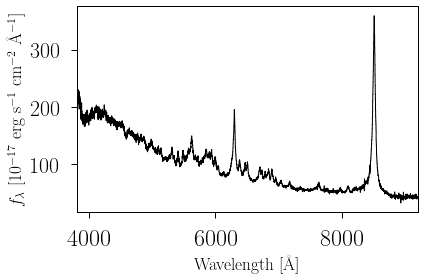

In [11]:
# plot flux versus wavelength
# include units on axis labels
# use drawstyle='steps-mid' to display spectra properly
fig = plt.figure()
ax  = plt.axes()
ax.plot(obs_wave,obs_flux,drawstyle='steps-mid',color='black')
ax.set_xlim(np.min(obs_wave),np.max(obs_wave))
ax.set_xlabel(r'Wavelength [\AA]')
ax.set_ylabel(r'$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]')
plt.tight_layout()  
plt.show()

# can you identify any of the emission lines?

# Get the redshift

Quasars are at cosmological redshifts. SDSS spectra store a pipeline redshift, which is calculated by identifying emission lines with known wavelengths in the spectrum. It is usually (but not always) reliable.

In [12]:
# grab the best redshift
z = hdu[2].data['Z']

# Correct the fluxes for Galactic extinction

Light from quasars is attenuated by dust in our own Galaxy and SDSS spectra are not corrected for this effect.

To correct for Galactic extinction, you will need to:
1. Use <a href="https://github.com/kbarbary/sfdmap">sfdmap</a> to load a map of dust in the Milky Way.
2. Calculate the amount of reddening, given by the color excess $E(B-V)$, along the line of sight to your target.
3. Calculate $A_{V}$, the magnitudes of extinction in the $V$ band, assuming $R_{V} = A_{V}/E(B-V) = 3.1$. This is appropriate for the Milky Way, but can differ in other galaxies.
4. Use a dust law from the <a href="https://extinction.readthedocs.io/en/latest/">extinction</a> package to translate magnitudes of extinction in the $V$ band to each wavelength in your wavelength array. Different grain compositions, grain sizes, etc. can cause different dust laws. The Fitzpatrick et al. (1999) is a good choice for Milky Way extinction.
5. Correct the flux and flux uncertainty arrays for Galactic extinction, following $f_{\lambda,\textrm{dered}} = f_{\lambda,\textrm{obs}} \times 10^{(0.4\times A_{\lambda})}$. Extinction has a built-in package for this.

In [13]:
# load the dust map
m   = sfdmap.SFDMap(path_dust)

In [14]:
# calculate reddening along the line of sight
ebv = m.ebv(ra,dec)

In [15]:
# calculate magnitudes of extinction
Av  = 3.1*ebv

In [16]:
# translate to other wavelengths
Alam = extinction.fitzpatrick99(obs_wave.astype('double'),Av)

In [17]:
# correct for extinction
flux = extinction.remove(Alam,obs_flux)

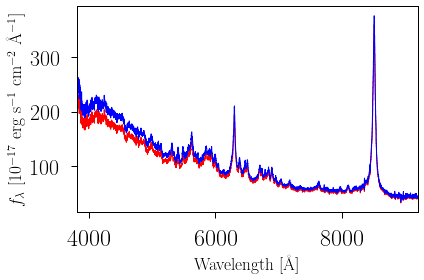

In [18]:
# plot and verify that the corrected flux is brighter
fig = plt.figure()
ax  = plt.axes()
ax.plot(obs_wave,obs_flux,drawstyle='steps-mid',color='red')
ax.plot(obs_wave,flux,drawstyle='steps-mid',color='blue')
ax.set_xlim(np.min(obs_wave),np.max(obs_wave))
ax.set_xlabel(r'Wavelength [\AA]')
ax.set_ylabel(r'$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]')
plt.tight_layout()  
plt.show()

# Correct for cosmic expansion

Remove the effect of redshift, by dividing wavelength array by $1+z$.

In [19]:
# calculate the rest wavelength
wave = obs_wave/(1+z)

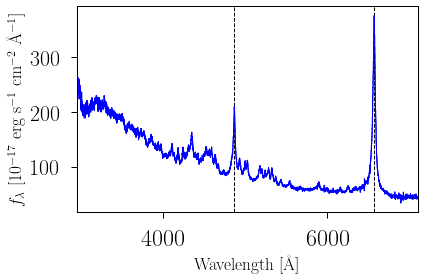

In [20]:
# plot and verify that there are strong emission lines 
# for H-alpha and H-beta
fig = plt.figure()
ax  = plt.axes()
ax.plot(wave,flux,drawstyle='steps-mid',color='blue')
ax.axvline(6563,color='k',linestyle='--')
ax.axvline(4863,color='k',linestyle='--')
ax.set_xlim(np.min(wave),np.max(wave))
ax.plot(wave,flux,drawstyle='steps-mid',color='blue')
ax.set_xlabel(r'Wavelength [\AA]')
ax.set_ylabel(r'$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]')
plt.tight_layout()  
plt.show()

# What's next?

Now you have a spectrum that's ready for further analysis. Other useful tasks include:

- Explore the process of downloading spectra, with the aim of doing as many steps as possible in Python. It's possible to run the entire thing from a Jupyter notebook.
- Automate all of the above steps, so that you can give a list of RAs and decs and obtain extinction corrected, rest-frame spectra.
- What could scientific analysis look like? You might do a spectral decomposition, e.g. using a package like <a href="https://github.com/legolason/PyQSOFit">this</a>, to isolate the continuum and width of a broad line so that you can <a href="https://ui.adsabs.harvard.edu/abs/2006ApJ...641..689V/abstract">calculate black hole mass</a>.